In [2]:
#!pip install autokeras


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

from sklearn.datasets import load_files
from tensorflow.keras.datasets import mnist
import autokeras as ak

import plotly.express as px
import copy 
import os
import json

from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

To make this tutorial easy to follow, we just treat MNIST dataset as a
regression dataset. It means we will treat prediction targets of MNIST dataset,
which are integers ranging from 0 to 9 as numerical values, so that they can be
directly used as the regression targets.

## A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an
example


In [4]:
data = pd.read_csv('new_multiclasses.csv')
data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y
0,fake_00001.pgm,0,1,0,0,1,0,0.892528,0.000000,ps1+ice
1,fake_00002.pgm,0,0,1,1,0,0,0.581729,0.568217,ps2+multi
2,fake_00003.pgm,0,1,0,0,0,0,0.508285,0.000000,ps1
3,fake_00004.pgm,0,1,0,0,0,0,0.852589,0.000000,ps1
4,fake_00005.pgm,0,0,1,0,0,0,0.762097,0.000000,ps2
...,...,...,...,...,...,...,...,...,...,...
26573,fake_38737.pgm,0,1,0,0,0,0,0.897076,0.000000,ps1
26574,fake_38738.pgm,0,1,0,0,0,0,0.646006,0.000000,ps1
26575,fake_38740.pgm,0,1,1,1,0,0,0.529205,0.716043,ps1+ps2+multi
26576,fake_38741.pgm,0,1,0,0,0,0,0.752521,0.000000,ps1


In [5]:
size = 2000
imgs = []
imgs_arr = []
imgs_drop = []
for f in data['file'][:size]:
    f = f.replace('pgm','png')
    try:
        image = tf.keras.preprocessing.image.load_img("./training_data/{}".format(f), color_mode='grayscale') 
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        imgs.append(image)
        imgs_arr.append(image_array)
    except:
        imgs_drop.append(f)
print(len(imgs_drop))

0


In [7]:
input_arr = np.array(imgs_arr)  # Convert single image to a batch.
print(type(input_arr))
print(input_arr.shape)
x_train = np.squeeze(input_arr)
print(x_train.shape)

y_train = np.array(data['mos1'][:size])
print(y_train.shape)

<class 'numpy.ndarray'>
(2000, 512, 512, 1)
(2000, 512, 512)
(2000,)


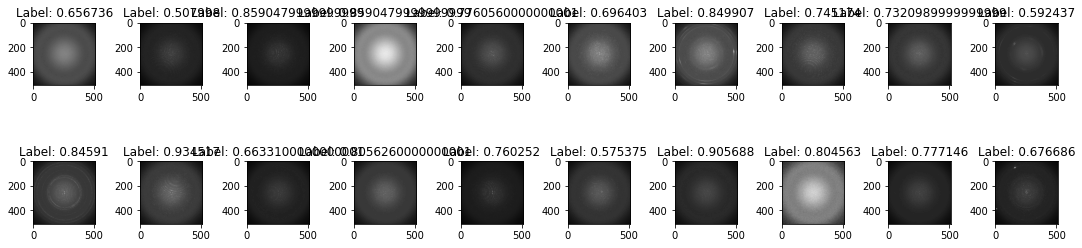

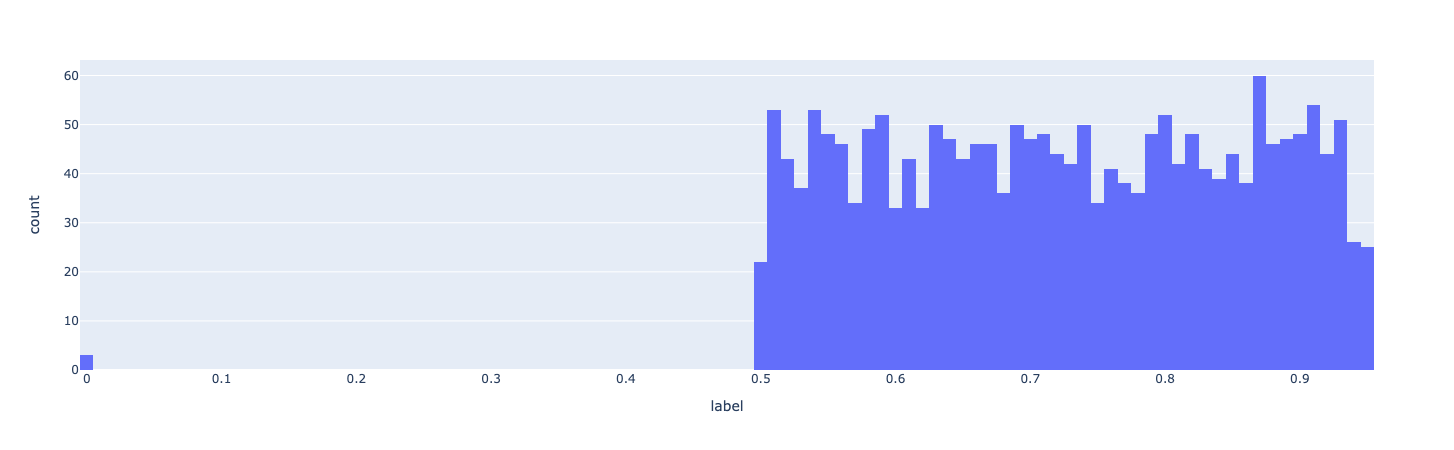

In [9]:
import matplotlib.pyplot as plt
num = 20
k=np.random.randint(len(y_train))
images = x_train[k:(k+num)]
labels = y_train[k:(k+num)]
num_row = 2
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

import plotly.express as px
df = pd.DataFrame(y_train, columns=['label'])
fig = px.histogram(df, x='label', nbins=100)
fig.show()

The second step is to run the ImageRegressor.  It is recommended have more
trials for more complicated datasets.  This is just a quick demo of MNIST, so
we set max_trials to 1.  For the same reason, we set epochs to 2.  You can also
leave the epochs unspecified for an adaptive number of epochs.


In [10]:
split = int(0.8 * size)

x_test = x_train[split:]
y_test = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]

In [ ]:
# Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=2)
# Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=20)


# Predict with the best model.
predicted_y = reg.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
image_block_1/n...|False             |?                 
image_block_1/a...|False             |?                 
image_block_1/b...|resnet            |?                 
image_block_1/r...|False             |?                 
image_block_1/r...|resnet50          |?                 
image_block_1/r...|False             |?                 
regression_head...|0                 |?                 
optimizer         |adam              |?                 
learning_rate     |0.001             |?                 

Epoch 1/20
40/40 [==============================] - 852s 21s/step - loss: 23589.4453 - mean_squared_error: 23589.4453 - val_loss: 1513302272.0000 - val_mean_squared_error: 1513302272.0000
Epoch 2/20
40/40 [==============================] - 846s 21s/step - loss: 27.0918 - mean_squared_error: 27.0918 - val_loss: 15063.8301 - val_mean_squared_error: 15063.8301
Epoch 3/20
40/40 [========================

In [ ]:
model = reg.export_model()
model.summary()

display(hyper_table(path='image_regressor'))
y_score = model.predict(x_test)
y_score_train = model.predict(x_train)

predic_error_analysis(x_train, y_train, y_score_train, x_test, y_test, y_score)